#Hometask 1 (Neural networks course, BSU)

Classifier for EMNIST.

##Preparing data

In [ ]:
!unzip bsu2021-emnist.zip

unzip:  cannot find or open bsu2021-emnist.zip, bsu2021-emnist.zip.zip or bsu2021-emnist.zip.ZIP.


###Loading data

In [ ]:
import numpy as np
# Load training data
data = np.load('emnist-byclass-train.npz')
train_labels = data['training_labels']
train_data = data['training_images']

# Load testing data
test_data = np.load('emnist-byclass-test.npz')['testing_images']

In [ ]:
train_len = int(len(train_labels) * 0.9)

X_train = train_data[:train_len]
y_train = train_labels[:train_len]

X_val = train_data[train_len:]
y_val = train_labels[train_len:]

In [ ]:
len(y_train), len(y_val)

(628138, 69794)

In [ ]:
from matplotlib import pyplot as plt
import skimage

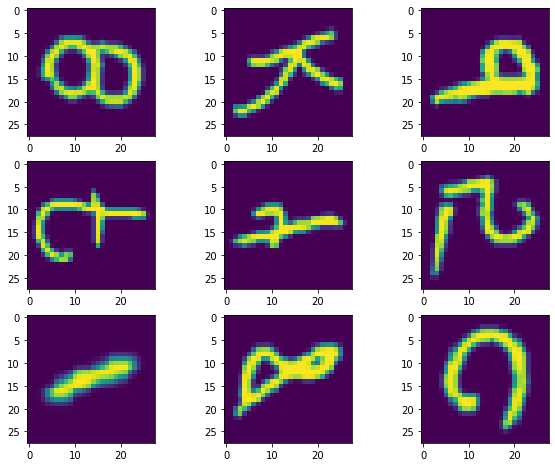

In [ ]:
plt.figure(figsize=(10,8))

for i in range(9):

    plt.subplot(3,3,i+1)
    im = skimage.img_as_ubyte(train_data[i])
    plt.imshow(im)


###Data augmentation

In [ ]:
# data augmentation
import torchvision
from torchvision import transforms
# import imageUtils


transform_train = transforms.Compose([
      transforms.RandomRotation([-20,20]),
#       transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
])


transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
from pathlib import Path
from torch.utils.data import Dataset
from skimage import io
from PIL import Image

class EMnistDataset(Dataset):

    def __init__(self, X, y=None, transform=None):
        self.transform = transform
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        image = self.X[idx] 
        if self.transform:
            image = self.transform(Image.fromarray(image))

        if self.y is not None:
            label = self.y[idx]
            return image, label
        else:
            return image

        
        


###Creating datasets

In [ ]:
train_dataset = EMnistDataset(X_train, y_train, transform=transform_train)
val_dataset = EMnistDataset(X_val, y_val, transform=transform_train)
test_dataset = EMnistDataset(test_data, transform=transform_test)

##Bulding a network

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

class StackedLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.first_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.first_batchnorm = nn.BatchNorm2d(out_channels)
        self.first_relu = nn.ReLU()
        self.second_conv = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.second_batchnorm = nn.BatchNorm2d(out_channels)
        self.second_relu = nn.ReLU()
        self.third_conv = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.third_batchnorm = nn.BatchNorm2d(out_channels)
        self.third_relu = nn.ReLU()
    def forward(self, x):
        out = self.first_conv(x)
        out = self.first_batchnorm(out)
        out = self.first_relu(out)
        out = self.second_conv(out)
        out = self.second_batchnorm(out)
        out = self.second_relu(out)
        out = self.third_conv(out)
        out = self.third_batchnorm(out)
        out = self.third_relu(out)

        return out + x

class MyResNet(nn.Module):
    """https://neurohive.io/ru/vidy-nejrosetej/resnet-34-50-101/"""
    def __init__(self, num_classes=62):
        super().__init__()
        model = nn.Sequential()

        model.add_module('conv_begin', nn.Conv2d(1, 32, kernel_size=3, stride=2))
        model.add_module('pool1', nn.MaxPool2d((2,2)))

        model.add_module('stacked1', StackedLayer(32,32))
        model.add_module('conv1', nn.Conv2d(32, 64, kernel_size=1))
        model.add_module('stacked2', StackedLayer(64,64))
        model.add_module('conv2', nn.Conv2d(64, 128, kernel_size=3))
        model.add_module('stacked3', StackedLayer(128,128))
        model.add_module('conv3', nn.Conv2d(128, 256, kernel_size=1))
        model.add_module('stacked4', StackedLayer(256,256))

        #model.add_module('stacked4', StackedLayer(64,64, stride=2)) 

        '''model.add_module('stacked5', StackedLayer(128,128))
        model.add_module('stacked6', StackedLayer(128,128))
        model.add_module('stacked7', StackedLayer(128,128))

        model.add_module('stacked8', StackedLayer(128,256, stride=2)) 

        model.add_module('stacked9', StackedLayer(256,256))
        model.add_module('stacked10', StackedLayer(256,256))
        model.add_module('stacked11', StackedLayer(256,256))
        model.add_module('stacked12', StackedLayer(256,256))
        model.add_module('stacked13', StackedLayer(256,256))

        model.add_module('stacked14', StackedLayer(256,512, stride=2)) 

        model.add_module('stacked15', StackedLayer(512,512))
        model.add_module('stacked16', StackedLayer(512,512))'''

        model.add_module('pool', nn.AvgPool2d((2,2)))
        model.add_module('flatten', nn.Flatten())

        model.add_module('dense1', nn.Linear(1024, 512))
        model.add_module("dense1_bn", nn.BatchNorm1d(512))
        model.add_module('dense1_relu', nn.ReLU())
        model.add_module('drop', nn.Dropout(0.3))
        model.add_module('dense2', nn.Linear(512, 256))
        model.add_module("dense2_bn", nn.BatchNorm1d(256))
        model.add_module('dense2_relu', nn.ReLU())
        model.add_module('dense3', nn.Linear(256, num_classes))

        

        self.model = model

    def forward(self, x):
        return self.model(x)

In [ ]:
model = MyResNet().cuda()
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 13, 13]             320
         MaxPool2d-2             [-1, 32, 6, 6]               0
            Conv2d-3             [-1, 32, 6, 6]           9,248
       BatchNorm2d-4             [-1, 32, 6, 6]              64
              ReLU-5             [-1, 32, 6, 6]               0
            Conv2d-6             [-1, 32, 6, 6]           9,248
       BatchNorm2d-7             [-1, 32, 6, 6]              64
              ReLU-8             [-1, 32, 6, 6]               0
            Conv2d-9             [-1, 32, 6, 6]           9,248
      BatchNorm2d-10             [-1, 32, 6, 6]              64
             ReLU-11             [-1, 32, 6, 6]               0
     StackedLayer-12             [-1, 32, 6, 6]               0
           Conv2d-13             [-1, 64, 6, 6]           2,112
           Conv2d-14             [-1, 6

##Training

In [ ]:
import gc
import time

from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

num_epochs = 15 # total amount of full passes over training data
batch_size = 64  # number of samples processed in one SGD iteration

train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

train_loss = []

val_loss = []
val_accuracy = []


for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in tqdm(train_loader):
        # train on batch
        loss = criterion(model(X_batch.cuda()), y_batch.long().cuda())
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        gc.collect()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    y_batch_values = []
    y_pred_values = []
    for X_batch, y_batch in tqdm(val_loader, desc="val"):
        logits = model(Variable(torch.FloatTensor(X_batch).cuda()))

        y_pred = logits.argmax(-1)
        val_loss.append(loss.data.cpu().numpy())
        gc.collect()
        #val_accuracy = accuracy_score(y_batch, y_pred)
        y_batch_values.append(y_batch)
        y_pred_values.append(y_pred)
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  val loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-len(val_loader) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.6f} ".format(
        accuracy_score(torch.cat(y_batch_values).cpu() , torch.cat(y_pred_values).cpu())))

<ipython-input-15-e0e83f229c6a>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for X_batch, y_batch in tqdm(train_loader):


<ipython-input-15-e0e83f229c6a>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for X_batch, y_batch in tqdm(val_loader, desc="val"):



Epoch 1 of 15 took 749.019s
  training loss (in-iteration): 	0.403421
  val loss (in-iteration): 	0.297989
  validation accuracy: 			0.856664 



Epoch 2 of 15 took 782.531s
  training loss (in-iteration): 	0.395921
  val loss (in-iteration): 	0.354889
  validation accuracy: 			0.855389 


KeyboardInterrupt: 

##Predicting

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=3)

###Making predictions

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
y_pred_values = []
for X_batch in tqdm(test_loader, desc="test"):
    logits = model(Variable(torch.FloatTensor(X_batch).cuda()))
    y_pred = logits.argmax(-1)
    y_pred_values.append(y_pred)

<ipython-input-17-2d68f42c713e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for X_batch in tqdm(test_loader, desc="test"):


In [ ]:
y_pred = torch.cat(y_pred_values).cpu()

In [ ]:
y_pred.numpy()

array([ 5,  7, 16, ...,  0, 25, 24])

In [ ]:
import pandas as pd

df = pd.DataFrame(np.array([np.arange(len(y_pred)), y_pred.numpy()]).T, columns=['Id', 'Category'])
df

,Id,Category
0,0,5
1,1,7
2,2,16
3,3,1
4,4,6
...,...,...
116318,116318,6
116319,116319,0
116320,116320,0
116321,116321,25


###Saving predictions

In [ ]:
df.to_csv('pred.csv', index=False)